<a href="https://colab.research.google.com/github/YuliaConstien/Cybergrooming_Detection_IM/blob/main/src/EnglishBERT_Testing_GermanChats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install hugging face evaluate 
!pip install evaluate 

In [ ]:
# install transformers 
!pip install transformers

In [4]:
#imports 

import pandas as pd
import numpy as np

from textwrap import wrap


from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


import transformers

import seaborn as sns
import matplotlib.pyplot as plt

from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers import TextClassificationPipeline
from transformers import pipeline

import evaluate

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score  

from sklearn.metrics import confusion_matrix, classification_report  
%matplotlib inline


In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load model
#tokenizer = AutoTokenizer.from_pretrained("Constien/IM_Model")

#model = AutoModelForSequenceClassification.from_pretrained("Constien/IM_Model")

In [26]:
# German Testset

train_seg = pd.read_csv('/content/drive/MyDrive/IM/VTPAN_csv/train_seg.csv')
val_seg = pd.read_csv('/content/drive/MyDrive/IM/VTPAN_csv/val_seg.csv')

ger_testset=pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /test_german.csv")


In [59]:
print(f'test dataset', ger_testset.shape)

test dataset (15329, 6)


In [27]:
#one-hot encoding the labels 
def to_sentiment(label):
  if label == True:
    return 1
  elif label == False:
    return 0

ger_testset['label'] = ger_testset['label'].apply(to_sentiment)

In [28]:
ger_testset.head(152)

,id,isCybergrooming,authors,messages,messages_de,label
0,de15188e9fd515ed817a0b34546be902,True,"[{'id': 'b6fe182274453b707870b16e5d2ad562', 'i...",[{'author': 'b6fe182274453b707870b16e5d2ad562'...,"['Rückseite', 'ok baby', 'was passiert Baby', ...",1
1,17784c5a093477c1706b1a68cea7c802,False,"[{'id': 'fcfda042c76436b97eca32b6c0490d1d', 'i...",[{'author': '713349f3afa2dbe352d2abe4d3f01a12'...,"['Hallo', 'Jungs sind Scheiß', 'dass sie', 'Ha...",0
2,15a38614944f5aa8bbb59d4153ecc12a,False,"[{'id': '454addae11c0b90c0f36a98b77aa07a6', 'i...",[{'author': 'ee792e8acb278ddd16cc46020c694b0b'...,"['Hallo', '19 m USA horny, u?', '2+2*2', '2+2*...",0
3,ee0aba2365c16a30cb36d1057a390b16,False,"[{'id': '471970f323f46dc39b5f07c6aa344686', 'i...",[{'author': 'bb2a120ae4ec93ef7c15f284b9b46544'...,"['f/m?', 'Hallo', 'da', 'f', 'u?', 'Hallo', 'm...",0
4,ca1b963746e368a4cec38ab4be3fdcf7,False,"[{'id': 'ed6658e6f22583ed66fb5e5e735b9e63', 'i...",[{'author': 'ed6658e6f22583ed66fb5e5e735b9e63'...,"['tut mir leid, ich bin jetzt wieder.', 'und f...",0
...,...,...,...,...,...,...
147,31dce06eff712b0115cdbee96658457e,False,"[{'id': 'd6c6208000043b6af62339da6f037a55', 'i...",[{'author': 'd6c6208000043b6af62339da6f037a55'...,"['?', '??', 'hallo~~~~~~~~~~~~~~~~~~~~~~~', 'H...",0
148,1a23bfbcb909c043cc6d99fd8335f769,False,"[{'id': '577ecaeaa448e7aba6d2859d58ae37e2', 'i...",[{'author': '577ecaeaa448e7aba6d2859d58ae37e2'...,"['Penis?', 'Hallo', 'ja', 'u?', 'Sind Sie Homo...",0
149,49e99a177200e93d53cc2e55cfcce4c3,False,"[{'id': 'e34c85accdea0132e3d8c3530f00df50', 'i...",[{'author': 'e34c85accdea0132e3d8c3530f00df50'...,"['hey', 'Hallo', 'Asi', '19', 'hey hey', 'f', ...",0
150,9723ee787c4a2ae853a514fc1cffb2cc,True,"[{'id': '9d2f75377ac0ab991d40c91fd27e52fd', 'i...",[{'author': '9d2f75377ac0ab991d40c91fd27e52fd'...,"['hey', 'wie ist meine sexy kleine Schlampe?',...",1


In [29]:
#data to list

X_train = list(train_seg["segment"])
y_train = list(train_seg["label"])
X_val = list(val_seg["segment"])
y_val = list(val_seg["label"])

X_test= list(ger_testset['messages_de'])
y_test = list(ger_testset["label"])


In [30]:
#tokenize 
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=512)

test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512)


In [17]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [31]:
#load dataset
train_dataset_S = Dataset(train_encodings, y_train)
val_dataset_S = Dataset(val_encodings, y_val)

test_dataset_ger = Dataset(test_encodings, y_test)

In [19]:
# Define Trainer
args = TrainingArguments(
    output_dir="IM_seg",
    num_train_epochs=3,
    per_device_train_batch_size=16

)
trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    train_dataset=train_dataset_S,
    eval_dataset=val_dataset_S)

In [ ]:
#train
#trainer.train()

**Testing monolingual EnglishBERT on German test data**

In [32]:
#get prediction from test data 
predictions = trainer.predict(test_dataset_ger)
preds = np.argmax(predictions.predictions, axis=-1)

In [33]:
# macro f1 on test data 
metric = evaluate.load("f1")
metric.compute(predictions=preds, references=y_test,  average="macro")

{'f1': 0.47489038092628116}

In [42]:
class_names = [ 'non_predator', 'Predator']

In [43]:
#classification report

print(classification_report(y_test, preds, target_names=class_names))

              precision    recall  f1-score   support

non_predator       0.90      1.00      0.95     13863
    Predator       0.00      0.00      0.00      1466

    accuracy                           0.90     15329
   macro avg       0.45      0.50      0.47     15329
weighted avg       0.82      0.90      0.86     15329



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


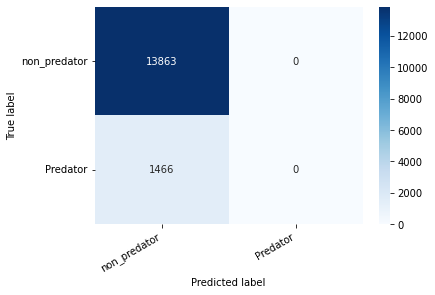

In [44]:
#confusion matrix 
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [58]:
#example from the test data and its true and predicted labels
idx = 0
review_text = X_test[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': preds[idx]
}) 
print("\n".join(wrap(review_text)))
print()
print(f'True label: {class_names[true_sentiment]}')
print()
print(f'Predicted label: {preds[idx]}')


['Rückseite', 'ok baby', 'was passiert Baby', 'Hund wollte heraus n
dann zog sie ab laufend die Straße hinunter', 'Oh Mann ich hasse das
was für eine Art von Gott?', 'Drahthund', 'ic ich habe einen Pitbull
er ist ein süßes Herz', 'kühle', 'er denkt, er sei ein kleiner Hund',
'lol', 'mag er 2 sit n ur lap?', 'wenn er seinen Weg hatte, würde er
es tun, aber er wird sich ausstrecken und die Couch übernehmen',
'lol', 'wollen seine Baby-Fotos sehen', 'AWWWWW', 'hes SOOOOO
niedlich!!', 'eine geöffnet', 'die anderen 2 nicht', 'ok', 'er ist so
klein', 'ja, aber nicht mehr', 'was machst du?', 'wo wo u wo und tun
Baby', 'Ich bin hier', ':) ok', '>:D<', '>:D<;;):-*', 'Sie wissen, was
Baby Ihr sssoooo allsome', 'Danke!', 'Scotland', 'Haben Sie Abendessen
noch gegessen?', 'ja ich bestellte papjohns pizza und u baby', 'werde
jetzt gehen essen', 'wird u b in später?', 'ok babby was du essest?',
'Hühner', 'mmm', 'bbl', ':-*', 'PO', 'ok', ':-*']

True label: Predator

Predicted label: 0
